# BERT Word Embeddings

https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d

Three ways to obtain word embeddings from BERT:
- context-free 
- context-based
- context-averaged

## Setup

Install `torch` and `transformers` if you have not yet done so:

In [ ]:
#!pip install torch
#!pip install transformers

Load all required modules:

In [1]:
# for data wrangling
import pandas as pd
import numpy as np

# for BERT
from transformers import BertTokenizer, BertModel
import torch

# for visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')


Load the model and its tokenizer

In [2]:
# Loading the pre-trained BERT model
###################################
# Embeddings will be derived from the outputs of this model
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,
                                  )

# Setting up the tokenizer
###################################
# This is the same tokenizer that was used in the model to generate embeddings to ensure consistency
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Define the list of sentences containing the same word (here, 'bank') we want to analyze/compare: 

In [5]:
# Text corpus
##############
# These sentences show the different forms of the word 'bank' to show the value of contextualized embeddings

texts = [
    "bank", # <== inlcude the get the uncontextualized ('static') embedding
    # define sentences that use 'bank' in different sense 
    "The river bank was flooded.",
    "The bank vault was robust.",
    "He had to bank on her for support.",
    "The bank was out of money.",
    "The bank teller was a man."
]

Define two helper functions that retrieve the focal words' (un)contextualized embedding:

In [3]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors
    
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

## Analyses

Below, we obtain the (un)contextualized embeddings of the focus word and compare them

In [6]:
# Getting embeddings for the target word in all given contexts
target_word_embeddings = []
focus_word = 'bank'

for text in texts:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    
    # Find the position 'bank' in list of tokens
    word_index = tokenized_text.index(focus_word)
    # Get the embedding for bank
    word_embedding = list_token_embeddings[word_index]

    target_word_embeddings.append(word_embedding)

Next, we comptue the cosine similarity between each pair of embeddings.
In this way, we can directly compare how similar the (un)contextualized embedding of the focus word ("bank") is given two different sentence contexts.

In [54]:
from scipy.spatial.distance import cosine

# Calculating the distance between the embeddings of 'bank' in all the given contexts of the word

list_of_similarities = []
for text1, embed1 in zip(texts, target_word_embeddings):
    for text2, embed2 in zip(texts, target_word_embeddings):
        cos_dist = 1 - cosine(embed1, embed2)
        list_of_similarities.append([text1, text2, cos_dist])

similarities_df = pd.DataFrame(list_of_similarities, columns=['text1', 'text2', 'similarity'])

### Comparison to the word's 'static' embedding

Below, we compare the static embedding of "bank" (as a reference) to the contextualized embeddings of the word in different sentence contexts (column 'text2').

Below, row 0 is using the context-free embedding of 'bank'.
In contrast, the embeddings used in rows 1-5 stem from the word's contextualization by the context words in the sentences printed in column ('text2').

**_Importantly_**, we alwaays only compare the embeddings of the word bank (with and without contextualization) &mdash; not the entire sentences' embeddings to the word 'bank'!

In [55]:
similarities_df[similarities_df.text1 == 'bank']

,text1,text2,similarity
0,bank,bank,1.000000
1,bank,The river bank was flooded.,0.338063
2,bank,The bank vault was robust.,0.494098
3,bank,He had to bank on her for support.,0.256140
4,bank,The bank was out of money.,0.469941
5,bank,The bank teller was a man.,0.466020


Here is what we can learn from these comparisons:

- The contextualized embedding of 'bank' in sentences 2, 4, and 5 (i.e., the use of the word in the financial context) is relatively similar to the words static embedding.
- In contrast, when "bank" is used in its nature/river meaning, its contextualized embedding is comparatively less similar to the static embedding of "bank"
- This indicates that the financial meaning of the word "bank" dominantes the static (i.e., un-contextualized) embedding.
- But by adding context, we can shift its embedding according to the word as its used ... well, in context 🤷‍♂️  



The plot below illustrates this idea of the word "bank"'s differing embeddings depending on the contextual word sense.
For illustrative purposes, it plots 2-dimensional representations of the different (un)contextualized embeddings'.

**_Note_:** Remember that using PCA for dimensioanlity reduction, we slightly distort the relative distances between embeddings &mdash; but we'd say its still pretty informative.


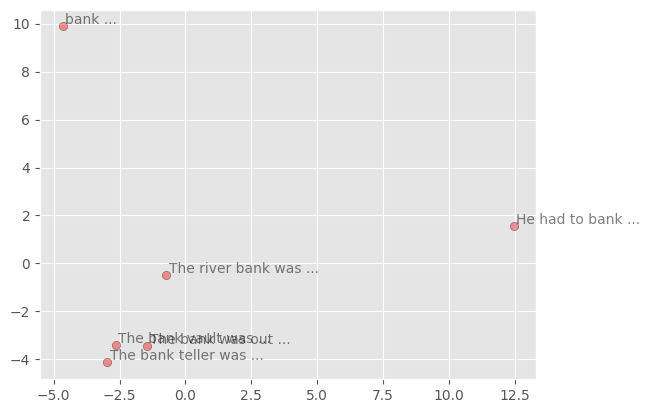

In [24]:
# show 2D plot of embeddings of 'bank'
X = np.array(target_word_embeddings)
pcs = PCA(n_components=2).fit_transform(X)

plt.scatter(pcs[:,0], pcs[:,1], c='r', edgecolors='k', alpha=.4)
for i, (x, y) in enumerate(pcs):
    plt.text(x+0.1, y+0.1, ' '.join(texts[i].split(' ')[:4])+' ...', alpha=.5)

We see 
- that embeddings of "bank" from the contexts in which it's used in its financial meaning cliuster close together.
- the embedding stemming from the river/nature context is a little further away
- even more apart is "bank"'s contextualized embedding stemming from the sentence 'He had to bank her ...'

### Comparison to the word's embedding in a reference sentence

We can repeat the same analysis comparing all cases to the embedding obtained in a reference sentence (shown in column 'text1').

In [56]:
similarities_df[similarities_df.text1 == 'The bank vault was robust.']

,text1,text2,similarity
12,The bank vault was robust.,bank,0.494098
13,The bank vault was robust.,The river bank was flooded.,0.523326
14,The bank vault was robust.,The bank vault was robust.,1.000000
15,The bank vault was robust.,He had to bank on her for support.,0.416074
16,The bank vault was robust.,The bank was out of money.,0.759213
17,The bank vault was robust.,The bank teller was a man.,0.867661


### Comparison of the average contextualized to the static embedding

Now we average the contextualized embeddings obtained from the word's different sentence contexts, and compute the similarity of this average embeddings with is uncontextualized/static embeddings:

In [57]:
cos_dist = 1 - cosine(target_word_embeddings[0], np.mean(target_word_embeddings, axis=0))
print(f'Similarity between context-free and context-averaged = {cos_dist}')

Similarity between context-free and context-averaged = 0.6590342296592141
